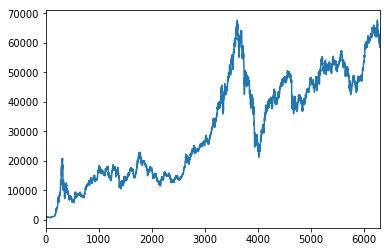

In [3]:
import click
import os
import numpy as np
import pandas as pd
import random
import time
from datetime import datetime
import tensorflow as tf
import tensorflow.contrib.slim as slim
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import matplotlib.pyplot as plt
from stock_rnn.scripts.build_graph import build_lstm_graph_with_config
from stock_rnn.scripts.train_model import train_lstm_graph
from stock_rnn.scripts.restore_model import prediction_by_trained_graph
from stock_rnn.scripts.config import DEFAULT_CONFIG, MODEL_DIR
from stock_rnn.data_model import StockDataSet

DATA_DIR = "stock_data"
NEW_DATA_DIR = "new_stock_data"
BOSSA_PL_STOCK_DATA_URL = "http://bossa.pl/pub/metastock/mstock/mstall.zip"
WIG_PATH = os.path.join(DATA_DIR, "WIG.mst")
TRAINING_MODEL_STOCK = "WIG"

#Simple method to plot prediction results in compare to data sample 
def plot_samples(preds, targets, stock_sym=None, multiplier=5):
        def _flatten(seq):
            return np.array([x for y in seq for x in y])

        truths = _flatten(targets)[-200:]
        preds = (_flatten(preds) * multiplier)[-200:]
        days = range(len(truths))[-200:]

        plt.figure(figsize=(12, 6))
        plt.plot(days, truths, label='truth')
        plt.plot(days, preds, label='pred')
        plt.legend(loc='upper left', frameon=False)
        plt.xlabel("day")
        plt.ylabel("normalized price")
        plt.ylim((min(truths), max(truths)))
        plt.grid(ls='--')

        if stock_sym:
            plt.title(stock_sym + " | Last %d days in test" % len(truths))
            
#Just to preview data
df_wig = pd.read_csv(WIG_PATH)
df_wig['<OPEN>'].plot()

In [ ]:
#Download newest stock data if not downloaded today and unzip
today = datetime.now()
today_dir = os.path.join(NEW_DATA_DIR, today.strftime('%Y%m%d'))

if(not os.path.exists(today_dir)): 
   os.makedirs(today_dir)
   resp = urlopen(BOSSA_PL_STOCK_DATA_URL)
   zipfile = ZipFile(BytesIO(resp.read()))
   zipfile.extractall(today_dir)

In [30]:
#Build graph and train it for stock symbol provided
lstm_graph = build_lstm_graph_with_config(config=DEFAULT_CONFIG)
train_lstm_graph('WIG', lstm_graph, config=DEFAULT_CONFIG)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train data size: 5646
Test data size: 628
Graph Name: WIG_lr0.00_lr_decay0.990_lstm128_step30_input1_batch64_epoch50
Middle learning rate: 0.0008097278682212584
Epoch 0 [0.001000]: 0.000132731
Predictions: [(<map object at 0x7ff3c16e24a8>, <map object at 0x7ff3c15c2ac8>), (<map object at 0x7ff3c15c2978>, <map object at 0x7ff3c15c2a20>), (<map object at 0x7ff3c15c2b00>, <map object at 0x7ff3c15c2be0>), (<map object at 0x7ff3c15c29b0>, <map object at 0x7ff3c15c2d68>), (<map object at 0x7ff3c15c2cc0>, <map object at 0x7ff3c15c28d0>)]
Epoch 10 [0.000941]: 0.000125969
Epoch 20 [0.000851]: 0.00010358
Epoch 30 [0.000770]: 0.000112663
Epoch 40 [0.000696]: 8.98393e-05
Final Results:
[[ -5.03482297e-04]
 [  7.13761244e-03]
 [ -1.11326762e-03]
 [ -1.38029642e-03]
 [ -3.46639007e-03]
 [  3.57818604e-03]
 [  4.20151278e-04]
 [ -2.08118372e-03]
 [ -1.48147345e-04]
 [ -3.13427113e-03]
 [  5.21708280e-04]
 [  1.37608312e-03]
 [  3.62722576e-03]
 [ -1.64488517e-03]
 [ -1.99535303e-03]
 [  7.14616850e-0

In [31]:
#Load trained graph and test on other stock data (or same)
TEST_MODEL_STOCK = "WIG20"

stock_data_set =  StockDataSet(
   TEST_MODEL_STOCK,
   input_size=1,
   num_steps=30,
   test_ratio=1.0)

In [32]:
#Load graph trained in previous step
graph_name = "%s_lr%.2f_lr_decay%.3f_lstm%d_step%d_input%d_batch%d_epoch%d" % (
        TRAINING_MODEL_STOCK,
        DEFAULT_CONFIG.init_learning_rate, DEFAULT_CONFIG.learning_rate_decay,
        DEFAULT_CONFIG.lstm_size, DEFAULT_CONFIG.num_steps,
        DEFAULT_CONFIG.input_size, DEFAULT_CONFIG.batch_size, DEFAULT_CONFIG.max_epoch)
test_prediction, test_loss = prediction_by_trained_graph(graph_name, DEFAULT_CONFIG.max_epoch, stock_data_set.test_X, stock_data_set.test_y)

INFO:tensorflow:Restoring parameters from models/WIG_lr0.00_lr_decay0.990_lstm128_step30_input1_batch64_epoch50/stock_rnn_model_WIG_lr0.00_lr_decay0.990_lstm128_step30_input1_batch64_epoch50.ckpt-49


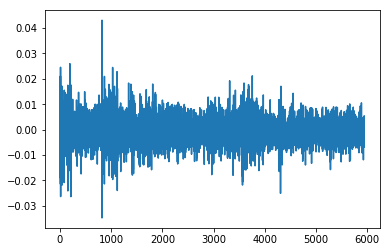

In [33]:
plt.plot(test_prediction)

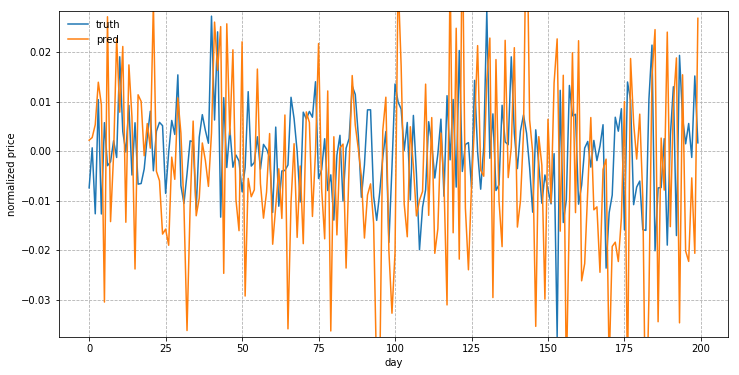

In [34]:
plot_samples(test_prediction, stock_data_set.test_y, TEST_MODEL_STOCK)